In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.io as sio
import scipy.signal as sig
import matplotlib.pyplot as plt

In [2]:
mat_data = sio.loadmat('HW6Spectral_2020.mat')
x = mat_data['x552csp'].flatten()
y = mat_data['y552csp'].flatten()
x = x - np.mean(x)
y = y - np.mean(y)

n = 256
n2 = n/2
f = np.linspace(0, n2, num=int(n2+1))/n

# plt.plot(x)
# plt.show()
# plt.plot(y)
# plt.show()

# Remove Annual Cycle

In [3]:
# Subtract monthly means from the data

nyr = 16
times = pd.date_range(start='01-01-2004',end='12-31-2019',freq='D')
times_1yr = pd.date_range(start='01-01-2004',end='12-31-2019',freq='MS')
month_days = [time.daysinmonth for time in times_1yr]
xx = xr.DataArray(data=x, coords={'time': times}, dims=['time'])
yy = xr.DataArray(data=y, coords={'time': times}, dims=['time'])

xmonthlymeans = xx.groupby('time.month').mean(dim='time')
xmm = np.repeat(np.tile(xmonthlymeans, nyr), month_days)
x_removed = xx - xmm

ymonthlymeans = yy.groupby('time.month').mean(dim='time')
ymm = np.repeat(np.tile(ymonthlymeans, nyr), month_days)
y_removed = yy - ymm

In [4]:
x = x_removed
y = y_removed

# Power Spectral Analysis

In [5]:
def lagcor(xx, yy, maxlag):
    # remove means
    xp = xx-np.mean(xx);
    mx = len(xp)
    yp = yy-np.mean(yy);
    
    rho0 = np.corrcoef(xp,yp)[1,0]
    lags = np.arange(-(mx-1),mx)    
    rho = np.correlate(xp,yp,mode='full')  # get all lags (2*mx -1)
    rho = rho/rho[lags==0] * rho0

    # trim to lags
    rho = rho[mx-maxlag-1:mx+maxlag]
    lags = lags[mx-maxlag-1:mx+maxlag]

    return lags, rho

def fstat(dof):
    """Adapted to python from Dennis Hartmann's fstat.m function."""
    f=[6.63,4.61,3.78,3.32,3.02,2.8,2.64,2.51,2.41,2.31,2.18,2.04,1.88,1.79,1.70,1.59,1.47,1.32,1.0];
    n=[1,2,3,4,5,6,7,8,9,10,12,15,20,24,30,40,60,120,1000000];

    for i in range(len(f)):
        if (dof <= n[i]):
            fstat = f[i-1]+(dof-n[i-1])*(f[i]-f[i-1])/(n[i]-n[i-1])
            return fstat
        else:
            fstat = f[18]
    return fstat

In [6]:
nlag = int(n2)
lagx, rhox = lagcor(x, x, nlag)
lagy, rhoy = lagcor(y, y, nlag)
lag1_x = (rhox[nlag+1] + np.sqrt(rhox[nlag+2]))/2
lag1_y = (rhoy[nlag+1] + np.sqrt(rhoy[nlag+2]))/2

rspec_x = np.array([(1-lag1_x**2)/(1-2*lag1_x*np.cos(np.pi*h/n2)+lag1_x**2) for h in range(nlag+1)])
rspec_y = np.array([(1-lag1_y**2)/(1-2*lag1_y*np.cos(np.pi*h/n2)+lag1_y**2) for h in range(nlag+1)])
# plt.plot(lagx[nlag:], rspec_x)
# plt.plot(lagy[nlag:], rspec_y)
# plt.show()

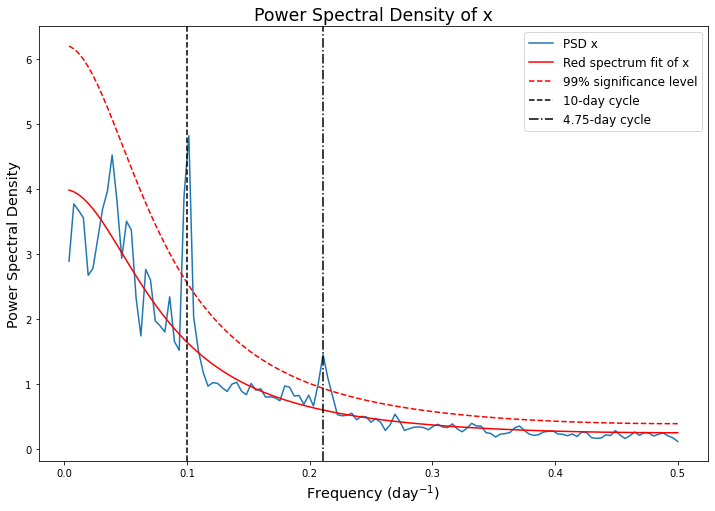

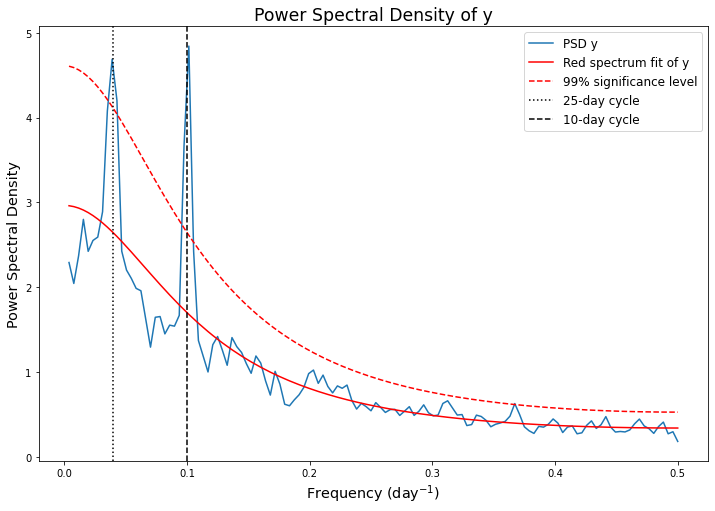

In [7]:
fx, pxx = sig.welch(x, window='hamming', nperseg=n)
fy, pyy = sig.welch(y, window='hamming', nperseg=n)

pxx = pxx / np.mean(pxx)
pyy = pyy / np.mean(pyy)

dof = len(x)/n2
fst = fstat(dof)
spec99_x = fst*rspec_x
spec99_y = fst*rspec_y

fourday = 1/4.75
tenday = 1/10
twentyfiveday = 1/25

fig = plt.figure(figsize=(12, 8))
plt.plot(fx[1:], pxx[1:], label='PSD x')
plt.plot(fx[1:], rspec_x[1:], label='Red spectrum fit of x', c='r')
plt.plot(fx[1:], spec99_x[1:], label='99% significance level', ls='--', c='r')
plt.axvline(tenday, c='k', ls='--', label='10-day cycle')
plt.axvline(fourday, c='k', ls='-.', label='4.75-day cycle')
plt.title('Power Spectral Density of x', size='xx-large')
plt.xlabel('Frequency (day$^{-1}$)', size='x-large')
plt.ylabel('Power Spectral Density', size='x-large')
plt.legend(fontsize='large')
plt.show()

fig1 = plt.figure(figsize=(12, 8))
plt.plot(fy[1:], pyy[1:], label='PSD y')
plt.plot(fy[1:], rspec_y[1:], label='Red spectrum fit of y', c='r')
plt.plot(fy[1:], spec99_y[1:], label='99% significance level', ls='--', c='r')
plt.axvline(twentyfiveday, c='k', ls=':', label='25-day cycle')
plt.axvline(tenday, c='k', ls='--', label='10-day cycle')
plt.title('Power Spectral Density of y', size='xx-large')
plt.xlabel('Frequency (day$^{-1}$)', size='x-large')
plt.ylabel('Power Spectral Density', size='x-large')
plt.legend(fontsize='large')
plt.show()

# Cross Spectral Analysis

In [8]:
def cohstat(dof, siglev):
    """Adapted to python from Dennis Hartmann's cohstat.m function."""
    f99=[0.99,0.684,0.602,0.536,0.482,0.438,0.401,0.342,0.264,0.215,0.175,0.147,0.112,0.075,0.057,0.045,0.023,0.002]
    f90=[0.901,0.437,0.370,0.319,0.280,0.250,0.226,0.189,0.142,0.112,0.091,0.076,0.057,0.038,0.029,0.023,0.011,0.001]
    f95=[0.951,0.527,0.450,0.393,0.348,0.312,0.283,0.238,0.181,0.146,0.118,0.098,0.074,0.050,0.037,0.030,0.015,0.001]
    n=[2,5,6,7,8,9,10,12,16,20,25,30,40,60,80,100,200,1000000]

    if (siglev > .95):
        f = f99
    else:
        f= f95

    for i in range(len(n)):
        if (dof <= n[i]):
            if i == 0:
                cohstat = f[0]
                return cohstat
            cohstat = f[i]-(n[i]-dof)*(f[i]-f[i-1])/(n[i]-n[i-1])
            return cohstat
        else:
            cohstat = f[17]
    return cohstat

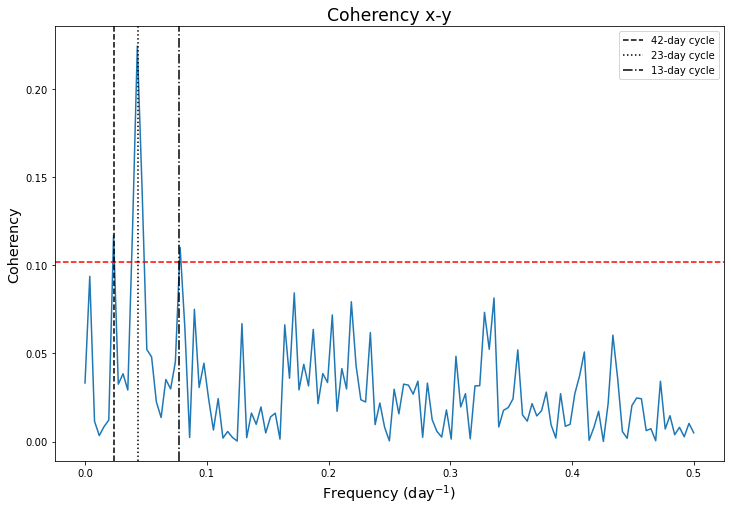

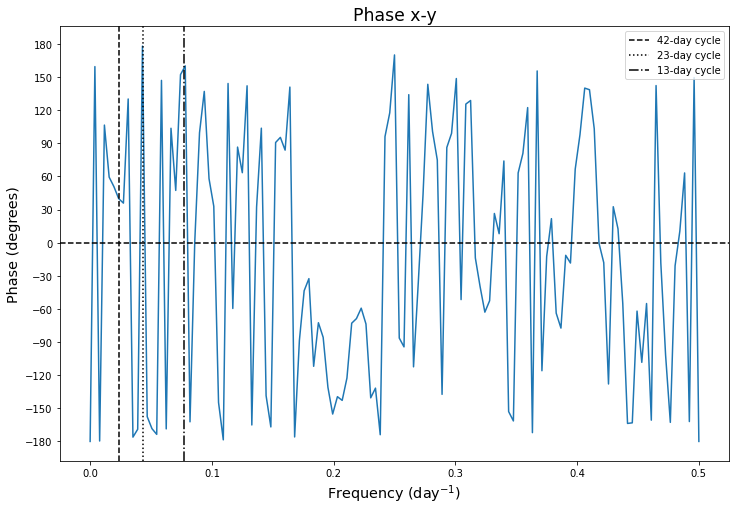

In [9]:
f1, Pxy = sig.csd(x, y, window='hamming', nperseg=n)  # cross power spectrum density
Cxy = np.sqrt(np.real(Pxy)*np.real(Pxy))  # co-spectrum amplitude
Qxy = np.sqrt(np.imag(Pxy)*np.imag(Pxy))  #quadrature spectrum amplitude
Crxy = np.sqrt(Pxy*np.conj(Pxy))  # cross-spectrum amplitude
f2, Cohxy = sig.coherence(x, y, window='hamming', nperseg=n)  # coherency
Phxy = np.arctan2(-np.imag(Pxy), np.real(Pxy))*180/np.pi  # phase in degrees

# find significance level
siglev = 0.99
cohcrit = cohstat(dof, siglev)

fortytwoday = 1/42
twentythreeday = 1/23
thirteenday = 1/13

fig = plt.figure(figsize=(12, 8))
plt.plot(f2, Cohxy)
plt.axhline(cohcrit, c='r', ls='--')
plt.axvline(fortytwoday, c='k', ls='--', label='42-day cycle')
plt.axvline(twentythreeday, c='k', ls=':', label='23-day cycle')
plt.axvline(thirteenday, c='k', ls='-.', label='13-day cycle')
plt.title('Coherency x-y', size='xx-large')
plt.xlabel('Frequency (day$^{-1}$)', size='x-large')
plt.ylabel('Coherency', size='x-large')
plt.legend()
plt.show()

fig1 = plt.figure(figsize=(12, 8))
plt.plot(f2, Phxy)
plt.axhline(0, c='k', ls='--')
plt.axvline(fortytwoday, c='k', ls='--', label='42-day cycle')
plt.axvline(twentythreeday, c='k', ls=':', label='23-day cycle')
plt.axvline(thirteenday, c='k', ls='-.', label='13-day cycle')
plt.title('Phase x-y', size='xx-large')
plt.xlabel('Frequency (day$^{-1}$)', size='x-large')
plt.ylabel('Phase (degrees)', size='x-large')
plt.yticks([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
plt.legend()
plt.show()